# Bayesian methods of Machine Learning (Skoltech)

## Home Assignment 2.  Log-Derivative trick. VAE. Mean-field approximation.

<img src="https://go2phystech.ru/wp-content/uploads/2021/02/skolteh.jpeg" width=800 height=200 />

### Important information

$\textbf{Deadline}$: 23:59:59, 10 November 2025 (Monday)\
$\textbf{Rules}$:
- You don't have to distribure materials of this homework, they belong to Skoltech.
- You don't have to use the help of other students. (otherwise, 0 points)
- You shouldn't postpone this homework.
- This HW costs 12 points.
- This HW is composed of 4 tasks with according points (2pts, 2pts, 4pts, 4pts).
- We created special telegram subgroup for this homework 2, where you can clarify some formal moments.
- You don't have to demonstrate your solution there or ask. (otherwise, 0 points)
- This HW might be appealed during the one week after the announcment of marks in offline format.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as TD
import torch.optim as optim
from torch.distributions import Normal, Bernoulli, Independent
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

from collections import defaultdict
from tqdm.notebook import tqdm, trange
from typing import List, Union
import gc
import os
import numpy as np
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from IPython.display import Image, display
from IPython.core.display import HTML
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device='cuda'
USE_CUDA=True

## Task 1. Log-derivative Trick (2 pts)

## 
1. In seminar 6 we encountered a problem with Monte Carlo estimation deriving the ELBO gradient at the E-step, since the distribution function $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})$ depends on the differentiation parameters $\boldsymbol{\phi}$.
\begin{align*}
    \nabla_{\boldsymbol{\phi}} \mathcal{L} (\boldsymbol{\phi}, \boldsymbol{\theta}) &= \nabla_{\boldsymbol{\phi}} \int q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) \left[\log p(\mathbf{x}, \mathbf{z} | \boldsymbol{\theta}) - \log q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi}) \right] d \mathbf{z} \\
    & \neq  \int q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) \nabla_{\boldsymbol{\phi}} \left[\log p(\mathbf{x}, \mathbf{z} | \boldsymbol{\theta}) - \log q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi}) \right] d \mathbf{z} \\
\end{align*}
The Reparametrization trick allowed us to skip the gradient and get a Monte Carlo estimate. 

    However, there is another way that uses the so-called **log-derivative trick**:
    $$
        \nabla_\xi  \log q(\eta| \xi) = \frac{\nabla_\xi q(\eta| \xi)}{q(\eta| \xi)}.
    $$
    
    Problems: 
    1. Get the Monte Carlo estimate of the gradient using the formula for the derivative of the logarithm. (1 pt)
    2. The final expression works significantly worse than the reparametrization trick. Namely, it has a huge variance. Try to describe the intuition why the evaluation has a high variance (you need to think about what order and sign the terms in the expression will have). (1 pt)

$\textbf{Solution:}$
1. Problem A

Let's get Monte Carlo estimation of the gradient $\nabla_{\boldsymbol{\phi}} \mathcal{L} (\boldsymbol{\phi}, \boldsymbol{\theta})$ with usage of the formula $\nabla_\xi  \log q(\eta| \xi) (1)$:
\begin{align*}
    \nabla_{\boldsymbol{\phi}} \mathcal{L} (\boldsymbol{\phi}, \boldsymbol{\theta}) &= \nabla_{\boldsymbol{\phi}} \int q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) \left[\log p(\mathbf{x}, \mathbf{z} | \boldsymbol{\theta}) - \log q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi}) \right] d \mathbf{z} = 
    \int \nabla_{\boldsymbol{\phi}} q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) \left[\log p(\mathbf{x}, \mathbf{z} | \boldsymbol{\theta}) - \log q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi}) \right] d \mathbf{z} - \int q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) \nabla_{\boldsymbol{\phi}} \log q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi}) d \mathbf{z}. (2)\\
\end{align*} 

Now let's note that from (1) we can state that $q(\eta| \xi) \cdot \nabla_\xi  \log q(\eta| \xi) = \nabla_\xi q(\eta| \xi)$. Cosequently the first term of expression (2) can be written as: 
\begin{align*}
    \int \nabla_{\boldsymbol{\phi}} q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) \left[\log p(\mathbf{x}, \mathbf{z} | \boldsymbol{\theta}) - \log q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi}) \right] d \mathbf{z} = \int q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) \nabla_{\boldsymbol{\phi}} \log q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi}) \left[\log p(\mathbf{x}, \mathbf{z} | \boldsymbol{\theta}) - \log q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi}) \right] d \mathbf{z}
\end{align*} 

But at the same time the second term in (2) equals to zero, let's prove this:
\begin{align*}
     - \int q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) \nabla_{\boldsymbol{\phi}} \log q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi}) d \mathbf{z} = - \int q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) \frac{1}{q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi})} \nabla_{\boldsymbol{\phi}} q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi}) d \mathbf{z} \\
= [ \text{now lets use the fact that we can put derivatives out of the integral} ] = \\
= \int \nabla_{\boldsymbol{\phi}} q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi}) d \mathbf{z} = \nabla_{\boldsymbol{\phi}} \int \nabla_{\boldsymbol{\phi}} q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi}) d \mathbf{z} = \nabla_{\boldsymbol{\phi}} (1) = 0 \quad \\
(\text{Because } q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi})\text{ is probability density and} \int q = 1)
\end{align*} 

Then we get:

\begin{align*}
    \nabla_{\boldsymbol{\phi}} \mathcal{L} (\boldsymbol{\phi}, \boldsymbol{\theta}) = \int q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) \nabla_{\boldsymbol{\phi}} \log q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi}) \left[\log p(\mathbf{x}, \mathbf{z} | \boldsymbol{\theta}) - \log q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi}) \right] d \mathbf{z}. 
\end{align*} 

And to get Monte-Carl oestimation we can sample $\{\mathbf{z}_i\}^{n}_{i=1}$ from $q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi})$ and get Monte-Carlo estimation of the gradient:
\begin{align*}
    \nabla_{\boldsymbol{\phi}} \mathcal{L} (\boldsymbol{\phi}, \boldsymbol{\theta}) = \sum_{i=1}^{n} \left[\log p(\mathbf{x}, \mathbf{z_i} | \boldsymbol{\theta}) - \log q(\mathbf{z_i}| \mathbf{x}, \boldsymbol{\phi}) \right] \nabla_{\boldsymbol{\phi}} \log q(\mathbf{z}_i| \mathbf{x}, \boldsymbol{\phi}). 
\end{align*} 

2. Problem B

During the lecture we have discussed that log-derivative trick has high variance because of Monte-Carlo estimation, but bellow we will consider some intuition of Monte-Carlo sampling problem of the task.

Let's carefully define each problem of this approach:
1. One of the main reason is possible high positive or negative value of $\log p(\mathbf{x}, \mathbf{z_i} | \boldsymbol{\theta}) - \log q(\mathbf{z_i}| \mathbf{x}, \boldsymbol{\phi})$. For example for high-dimensional spaces, each of logarithms $\log p(\mathbf{x}, \mathbf{z}_i)$ and $\log q(\mathbf{z}_i|\mathbf{x})$ could be veru large negative numbers. Consequently, their differences can be large positive or negative value depending on the sample, so there we need in very large number or sample. And moreover even with large samoles number we can obtain different results.
2. Other point, this difference also can change sign with different samples of $\{\mathbf{z}_i\}^{n}_{i=1}$ and therefore the gradient can always swing the direction and this highly affect on convergence of the model.
3. If we speak about the order of the expession than it can be very big even reach $O(N)$ with N denoted as big number of samples, than we have very slow learning process because this big absolute value could be positive or negative, as mentiones in 1, 2 points.

Also in the lecture we have noted that log-derivative trick could be optimized if we will sample separetly for different $\phi_i$ and then we can reduce error of $\log p(\mathbf{x}, \mathbf{z_i} | \boldsymbol{\theta}) - \log q(\mathbf{z_i}| \mathbf{x}, \boldsymbol{\phi})$ and make variance lower and control variance with some constant (variance of gradient can't be bigger than some constant).

## Task 2. VAE with no-gaussian decoder (2 pts)

We have familiarized ourselves with decoder model that describes the conditional distribution $p(x|z,\theta)$. We considered this model as gaussian distribution for simplicity. Thus, we assumed that data is described by normal distribution with mean and covariance matrix that are trainable. Nonetheless, one can take another distribution for certain tasks.

Let $\textbf{MNIST}$ data is our data for task. Then, our data looks like these images:

![Autoencoder reconstructions](https://github.com/bayesgroup/deepbayes-2018/blob/master/day2_vae/ae_reconstructions.png?raw=true)

One image of this dataset is some set of black and white pixels. By other words, some pixels are white and another are balck. Thus, decoder tries to set either white or black color for each pixel of generated image. So, we set either 0 or 1 for each coordinate of this generated image. As a consequence of that, our output of decoder has 2 possible outcomes and one can take $\textbf{bernoulli}$ distribution as $p(x|z,\theta)$.


A variational autoencoder consists of two components. The first component is a probabilistic model for observations: 
\begin{align}
& p(x, z \mid \theta) =  p(z) p(x \mid z, \theta) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid z, \theta) = \prod_{i = 1}^D p_i(z, \theta)^{x_i} (1 - p_i(z, \theta))^{1 - x_i}.
\end{align}
The second component is a variational approximation, used to compute the lower bound on marginal likelihood (VAE uses the negative lower bound as a loss function)
\begin{equation}
q(z \mid x, \phi) = \mathcal N(z \mid \mu(x, \phi), \operatorname{diag}(\sigma^2(x, \phi))).
\end{equation}
The lower bound for probability of observing $x$ from a minibatch is
$$ \mathcal L(x, \theta, \phi) = \mathbb E_{q(z \mid x, \phi)} \left[ \log p(x \mid z, \phi) + \log p(z) - \log q(z \mid x, \theta) \right] $$
However, it is impossible to compute the expectation. The standard practice is to approximate it with the following one-sample Monte-Carlo estimate:
\begin{align*}
\log p(x \mid z_0, \phi) + \log p(z_0) - \log q(z_0 \mid x, \theta) \\
z_0 = \mu(x, \phi) + \sigma^2(x, \phi)^T \varepsilon_0 \\
\varepsilon_0 \sim \mathcal N(0, I)
\end{align*}
*Note that this choice of the Monte-Carlo estimate for expectation is crucial and is typically reffered to as* **reparametrization trick.** For more details see [Auto-encoding Variational Bayes](https://arxiv.org/abs/1312.6114) paper.

Finally, to train the model we average the lower bound values over the minibatch and then maximize the average with gradient ascent:
$$ \frac{1}{N} \sum_{n=1}^N \log p(x_n \mid z_n, \phi) + \log p(z_n) - \log q(z_n \mid x_n, \theta) \rightarrow \max_{\theta, \phi} $$

### Encoder and decoder

$q(z\mid x, \theta)$ is usually called encoder and $p(x \mid z, \phi)$ is usually called decoder. To parametrize these distributions we introduce two neural networks:

- *enc* takes $x$ as input and return $2 \times d$-dimensional vector to parametrize mean and standard deviation of $q(z \mid x, \theta)$
- *dec* takes a latent representation $z$ and returns the logits of distribution $p(x \mid z, \phi)$.

The computational graph has a simple structure of autoencoder. The only difference is that now it uses a stochastic variable $\varepsilon$:

![vae](https://github.com/bayesgroup/deepbayes-2018/blob/master/day2_vae/vae.png?raw=true)

Below we initialize a couple of simple fully-connected networks to model the two distributions.

### 2.0 data for the experiment

Download MNIST data for this experiment an d divide it to train and test subsets.

In [3]:
# train dataset
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='.', train=True, download=True,
          transform=transforms.ToTensor()),
    batch_size=100, shuffle=True )

# Test dataset
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='.', train=False, transform=transforms.ToTensor()),
    batch_size=100, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.27MB/s]


### 2.1 Initializtion of models  (0.5 pt)

First of all, we initialize netorks for encoder and decoder  correspondingly. Below, we choose dimension of latent and data spaces. You should write appropriate architectures for encoder and decoder. (0.5 pt)

In [4]:
d = 32  # dimension of latent space 
nh = 100 # dinesnions of intermediate representations.
D = 28 * 28 # dimension of data space

In [5]:
# encoder
# your code is here
class Encoder(nn.Module):
    def __init__(self, input_size=D, layers_num=2, hidden_size=nh, output_size=d):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        
        self.layer_2 = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            ) for _ in range(layers_num)
        ])

        self.output_layer = nn.Linear(hidden_size, 2 * output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer_1(x)
        for layer in self.layer_2:
            x = layer(x)
        z = self.output_layer(x)
        return z

enc = Encoder()

Please, pay your attention! When we built decoder for $p(x|z,\phi)$ that is normal distribution, then such decoder has 2$D$ outputs, but you should correct outputs in this case of Bernoulli distribution. 

In [6]:
# decoder
# your code is here
class Decoder(nn.Module):
    def __init__(self, input_size=d, layers_num=1, hidden_size=nh, output=D):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        
        self.layer_2 = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            ) for _ in range(layers_num)
        ])

        self.output_layer = nn.Linear(hidden_size, output)
    
    def forward(self, z):
        z = z.view(z.size(0), -1)
        z = self.layer_1(z)
        for layer in self.layer_2:
            z = layer(z)
        x_hat = self.output_layer(z)
        return x_hat 
        
dec = Decoder()

In [7]:
device

'cuda'

In [8]:
enc = enc.to(device)
dec = dec.to(device)

### 2.2  VAE Loss function.  (0.5 pt)

Implement the line that corresponds to the loss function for the variational autoencoder (0.5 pt)

In [9]:
def loss_vae(x, encoder, decoder):
    """
    TODO
    returns
    1. the avergave value of negative ELBO across the minibatch x
    2. and the output of the decoder
    """
    batch_size = x.size(0)
    encoder_output = encoder(x)
    pz = Independent(Normal(loc=torch.zeros(batch_size, d).to(device),
                            scale=torch.ones(batch_size, d).to(device)),
                     reinterpreted_batch_ndims=1)
    qz_x = Independent(Normal(loc=encoder_output[:, :d],
                              scale=torch.exp(encoder_output[:, d:])),
                       reinterpreted_batch_ndims=1)
    
    z = qz_x.rsample()
    decoder_output = decoder(z)
    px_z = Independent(Bernoulli(logits=decoder_output), 
                       reinterpreted_batch_ndims=1)

    x_bin = (x > 0.5).float() 
    loss = - torch.mean(
        px_z.log_prob(x_bin) + pz.log_prob(z) - qz_x.log_prob(z)
    )
    
    return loss, decoder_output

### 2.3 Training

The cell below implements a simple training function that can be used for both models(encoder and decoder).

In [10]:
from itertools import chain

def train_model(loss, model, batch_size, num_epochs, learning_rate):
    gd = torch.optim.Adam(
        chain(*[x.parameters() for x in model
                if (isinstance(x, nn.Module) or isinstance(x, nn.Parameter))]),
        lr=learning_rate)
    train_losses = []
    test_results = []
    for _ in trange(num_epochs):
        for i, (batch, _) in enumerate(train_loader):
            total = len(train_loader)
            gd.zero_grad()
            batch = batch.view(-1, D).to(device)
            loss_value, _ = loss(batch, *model)
            loss_value.backward()
            train_losses.append(loss_value.item())
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            gd.step()
        test_loss = 0.
        for i, (batch, _) in enumerate(test_loader):
            batch = batch.view(-1, D).to(device)
            batch_loss, _ = loss(batch, *model)
            test_loss += (batch_loss - test_loss) / (i + 1)
        print('\nTest loss after an epoch: {}'.format(test_loss))

In [15]:
# choose appropiate hyper-parameters
# your code is here
BATCH_SIZE = 128
NUM_EPOCHS= 30
LR = 1e-3

In [16]:
enc = Encoder()
dec = Decoder()

enc = enc.to(device)
dec = dec.to(device)

In [17]:
train_model(loss_vae, model=[enc, dec], batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS, learning_rate=LR)

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 178.4303436279297 Batch 600 of 600            
Test loss after an epoch: 178.32925415039062
Train loss: 144.5163116455078 Batch 600 of 600            
Test loss after an epoch: 145.86119079589844
Train loss: 130.12744140625 Batch 600 of 600              
Test loss after an epoch: 131.0929718017578
Train loss: 130.5147705078125 Batch 600 of 600            
Test loss after an epoch: 124.56343078613281
Train loss: 125.95263671875 Batch 600 of 600              
Test loss after an epoch: 119.87261962890625
Train loss: 113.791015625 Batch 600 of 600                
Test loss after an epoch: 117.01461791992188
Train loss: 117.08839416503906 Batch 600 of 600           
Test loss after an epoch: 114.08841705322266
Train loss: 114.76905059814453 Batch 600 of 600           
Test loss after an epoch: 111.92051696777344
Train loss: 106.60474395751953 Batch 600 of 600           
Test loss after an epoch: 110.66049194335938
Train loss: 115.70384216308594 Batch 600 of 600           
Test l

### 2.4 Inference of VAE model (0.5 pt)

You should write the line, where we take latent codes and apply decoder model for these latent codes. (0.5 pt)

In [18]:
def sample_vae(dec, n_samples=50):
    with torch.no_grad():
        
        samples = Normal(0, 1).sample((n_samples, d))
        samples = dec(samples)
        samples = torch.sigmoid(samples)
        samples = samples.view(n_samples, 28, 28).cpu().numpy()
    return samples
    
def plot_samples(samples, h=5, w=10):
    fig, axes = plt.subplots(nrows=h,
                             ncols=w,
                             figsize=(int(1.4 * w), int(1.4 * h)),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap='gray')

We use trained decoder for the inference and obtain such results.

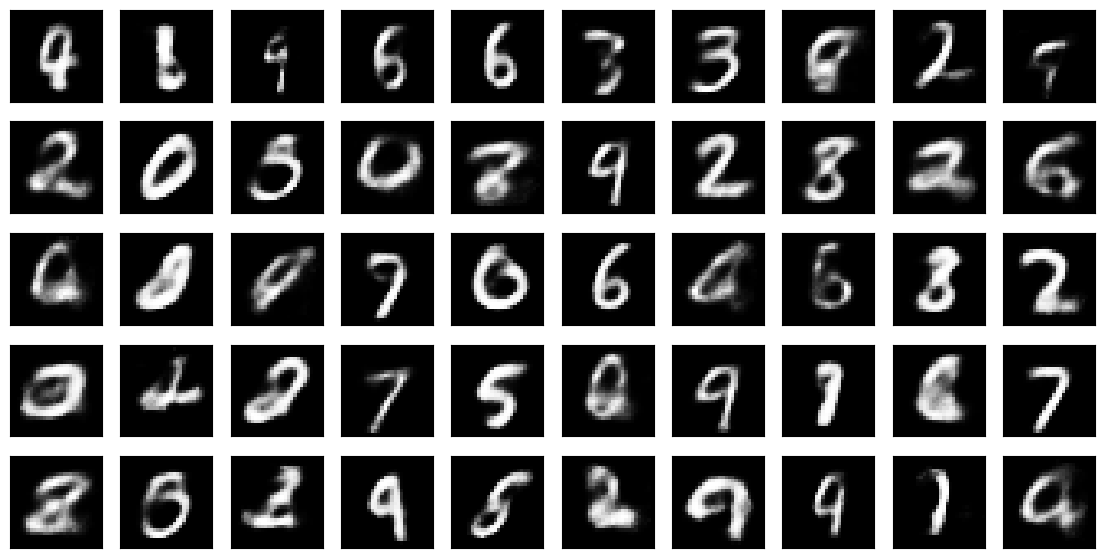

In [19]:
plot_samples(sample_vae(dec=dec.cpu()))

### 2.5 Plot reconstructions

Reconstruction corresponds to the following scenario. We take $x$ from dataset and perform mapping for this $x$ thankls to encoder model $q(z|x,\phi)$, then we make sampling from this distribution via reparanmetrization trcik and take this sample to decoder model $p(x|z,\theta)$. We believe that recostruction will be similar to initial data point. Our generated image is referred to as reconstruction by this way.

In [20]:
def plot_reconstructions(loss, model):
    with torch.no_grad():
        batch = (test_loader.dataset.data[:25].float() / 255.)
        batch = batch.view(-1, D).to(device)
        _, rec = loss(batch, *model)
        rec = torch.sigmoid(rec)
        rec = rec.view(-1, 28, 28).cpu().numpy()
        batch = batch.view(-1, 28, 28).cpu().numpy()
    
        fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(14, 7),
                                 subplot_kw={'xticks': [], 'yticks': []})
        for i in range(25):
            axes[i % 5, 2 * (i // 5)].imshow(batch[i], cmap='gray')
            axes[i % 5, 2 * (i // 5) + 1].imshow(rec[i], cmap='gray')

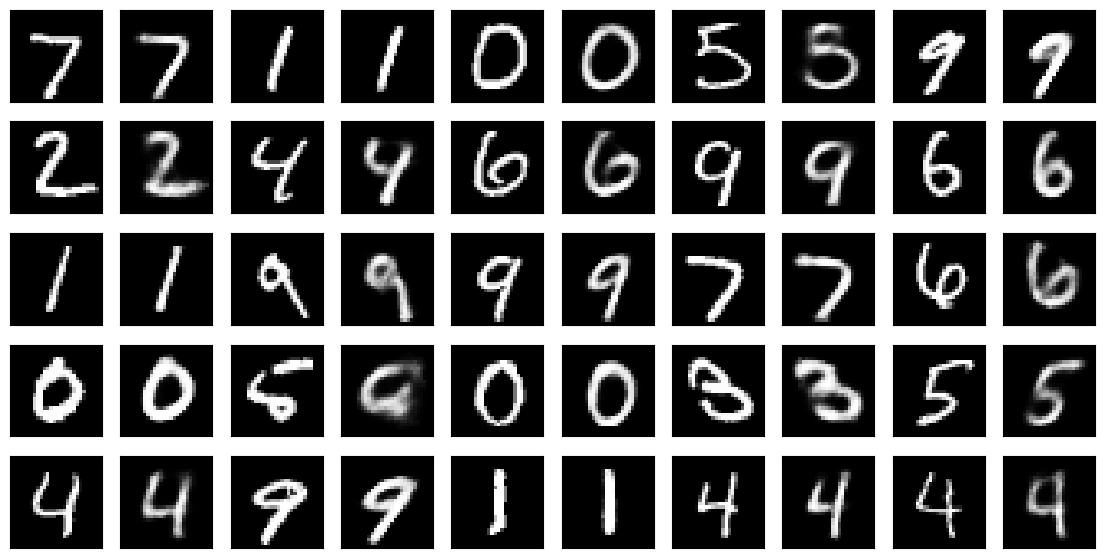

In [21]:
plot_reconstructions(loss_vae, [enc.to(device), dec.to(device)])

### 2.6 Plot interpolations

The first attempt to understand latent space of VAE is interploations. We take two latent codes $z_{0}$ and $z_{1}$ and build the forward line between them and  we try decode sample along the line.

In [22]:
def plot_interpolations(encoder, decoder):
    with torch.no_grad():
        batch = (test_loader.dataset.data[:10].float() / 255.)
        batch = batch.view(-1, D).to(device)
        batch = encoder(batch)
        z_0 = batch[:5, :d].view(5, 1, d)
        z_1 = batch[5:, :d].view(5, 1, d)
        
        alpha = torch.linspace(0., 1., 10).to(device)
        alpha = alpha.view(1, 10, 1)
        
        interpolations_z = (z_0 * alpha + z_1 * (1 - alpha))
        interpolations_z = interpolations_z.view(50, d)
        interpolations_x = torch.sigmoid(decoder(interpolations_z))
        interpolations_x = interpolations_x.view(5, 10, 28, 28).cpu().numpy()
    
    fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(14, 7),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i in range(50):
        axes[i // 10, i % 10].imshow(interpolations_x[i // 10, i % 10], cmap='gray')

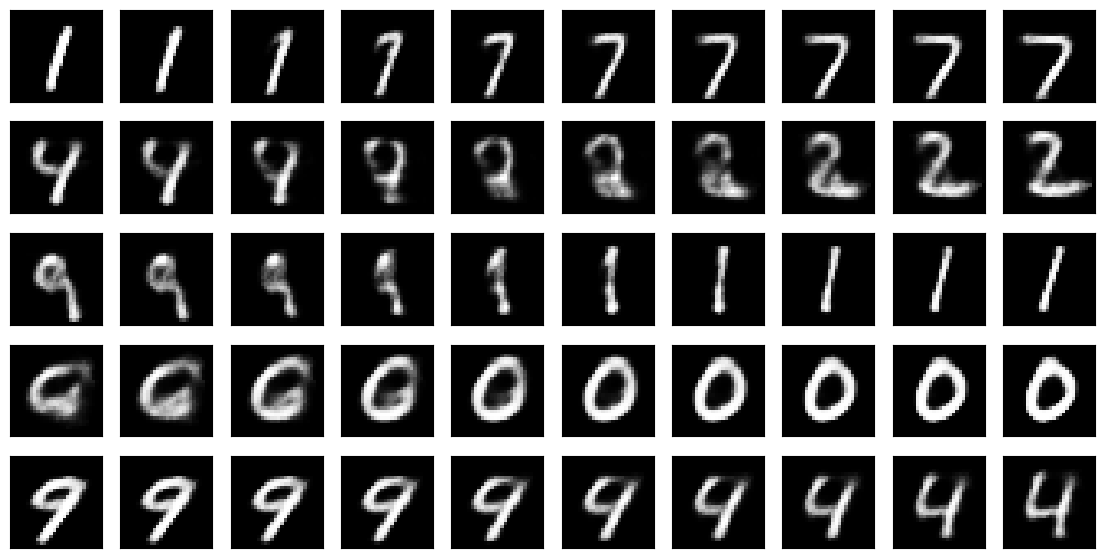

In [23]:
plot_interpolations(enc, dec)

### 2.7 Plot latent space of VAE model

Also, one can learn the structure of latent spaces thanks to methods of geometric ml(metric lerning) such [T-sne](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

In [24]:
def plot_tsne(objects, labels):
    from sklearn.manifold import TSNE
    embeddings = TSNE(n_components=2).fit_transform(objects)
    plt.figure(figsize=(8, 8))
    for k in range(10):
        embeddings_for_k = embeddings[labels == k]
        plt.scatter(embeddings_for_k[:, 0], embeddings_for_k[:, 1],
                    label='{}'.format(k))
    plt.legend()

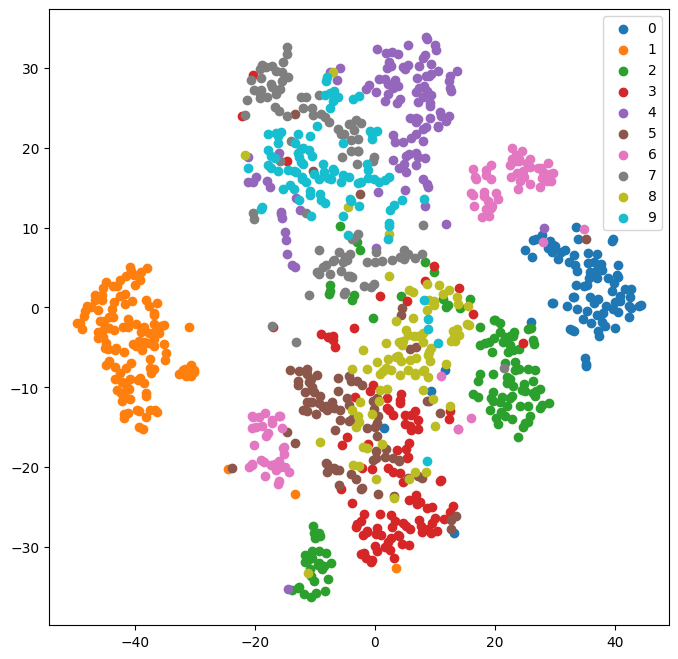

In [25]:
with torch.no_grad():
    batch = (test_loader.dataset.data[:1000].float() / 255.)
    batch = batch.view(-1, D).to(device)

    latent_variables = enc(batch)[:, :d]
    latent_variables = latent_variables.cpu().numpy()
    labels = test_loader.dataset.targets[:1000].numpy()

plot_tsne(latent_variables, labels)

###   2.8 Observations (0.5 pts)

Describe your results above and ask to the following questions
  
- Is the latent space regularly covered? 
- Is there any dependence between T-SNE encoding and the digit label?

1. Yes coverage of latent space is good, but need some improvments. There are some sparce space between cluster and cluster 1 is located a bit out of all other clusters. Moreover some clusters are much tighter than others. But still distribution of digits in latent space is good, because most digits form different groups. Clusters aren't just single point cloud and they allmost regulary covered all latent space. For example on test images allmost all digits predicted well, some uceratncy have found only with one number (it's 5 or 6 we can't state it clearly).

2. Yes, there are some dependences between T-SNE and digit label. For example, on graphs it's seen that T-SNE encoding can clearly define digit almost all digits. 

## Task 3. Mean-field approximation (4 pts)

We have already built approximation by mean-field methodology during the 5th seminar. This task is almost the same but for another distributions.

Consider a following model for i.i.d data $\mathcal{D}=\{x_1,\dots,x_N\}$, $N\geq2$ and $x_{i} \in \mathbb{R}$

We assume that our data distribution is described with a uniform distribution with a following prior distribution over parameters:
\begin{align*}
p(x \mid \lambda)&=\operatorname{Uniform}(x\mid0,\; \lambda)\\
p(\lambda \mid \tau) &= \operatorname{Pareto}(\lambda\mid \gamma_0,\; \alpha_0\tau),\\
p(\tau) &= \operatorname{Gamma}(\tau\mid u_0,\; v_0),
\end{align*}

$\textbf{Full task}:$ Find the approximation of true posterior $p(\lambda,\tau\mid\mathcal{D})$ using mean-field approximation $q(\lambda,\tau)=q_{\lambda}(\lambda)q_{\tau}(\tau)$

$\textbf{Recap}:$

Densities:
\begin{align*}
\operatorname{Uniform}(x\mid a, b) &= \frac{1}{b-a},\;\; x \in [a, b]\\
\operatorname{Pareto}(x\mid x_m, \alpha) &= \frac{\alpha x_m^{\alpha}}{x^{\alpha+1}},\;\; x \geq x_m\\
\operatorname{Gamma}(x\mid\alpha, \beta) &= \frac{\beta^{\alpha}}{\Gamma(\alpha)} x^{\alpha-1} e^{-\beta x},\;\; x \geq 0\\
\end{align*}

Moments:
$$
X\sim\operatorname{Gamma}(\alpha, \beta)\Rightarrow \mathbb{E}X=\frac{\alpha}{\beta}
$$
$$
X\sim\operatorname{Pareto}(x_m, \alpha), \text{ and } \alpha>1 \Rightarrow \mathbb{E}X=\frac{\alpha x_m}{\alpha-1}, \text{ and }\;\mathbb{E}\ln X=\ln x_m + \frac{1}{\alpha}
$$

$\textbf{Hint}$:
Don't forget about conjugate distributions.

### 3.1 Derive formulas for the first parameter (1 pt)

Firstly, you should derive and get formulas for $ q_{\lambda}(\lambda)$

With theory of Mean-field approximation we know that if there are only two parametrs $\lambda$ and $\tau$, then:
- $\log q_{\lambda}^{*} (\lambda) = \mathbb{E}_{\tau}[\log p(D, \lambda, \tau)]$
- $\log q_{\tau}^{*}(\tau) = \mathbb{E}_{\lambda}[\log p(D, \lambda, \tau)]$

First, let's consider following probability:  $$ p(D, \lambda, \tau) = p(D| \lambda, \tau) * p(\lambda| \tau) * p(\tau).$$
Then, $\log p(D, \lambda, \tau) = \log p(D| \lambda, \tau) + \log p(\lambda| \tau) + \log p(\tau).$ But also $p(D|\lambda, \tau)$ doesn't depend on $\tau$ and consequently we can write: $$\log p(D, \lambda, \tau) = \log p(D| \lambda) + \log p(\lambda| \tau) + \log p(\tau) = \sum_{i=1}^N \log p(x_i| \lambda) + \log p(\lambda| \tau) + \log p(\tau).$$

From task condition we can state:

- $\log p(x_i| \lambda) = \log \frac{1}{\lambda} + \log I[x_i \leq \lambda]\Rightarrow \sum_{i=1}^N \log p(x_i| \lambda) = - N \log \lambda + \log I[max_i(x_i)\leq \lambda]$
- $\log p(\lambda| \tau) = \log \alpha_0 + \log \tau + \alpha_0 \tau \log \gamma_0 - (\alpha_0 \tau + 1) \log \lambda + \log I[\gamma_0 \leq \lambda] $
- $\log p(\tau) =  v_0 \log u_0 - \log \Gamma (u_0) + (u_0 - 1) \log \tau - v_0 \tau$

Then we can start deriviation for $q_{\lambda}^{*} (\lambda)$:
$$\log q_{\lambda}^{*} (\lambda) = \mathbb{E}_{\tau}[- N \log \lambda + \log I[max_i(x_i)\leq \lambda] + \log \alpha_0 + \log \tau + \alpha_0 \tau \log \gamma_0 - (\alpha_0 \tau + 1) \log \lambda + \log I[\gamma_0 \leq \lambda] - v_0 \tau + v_0 \log u_0 - \log \Gamma (u_0) + (u_0 - 1) \log \tau ] =$$
$$ = - N \log \lambda + \log \alpha_0 + \log I[max_i(x_i)\leq \lambda] + \log I[\gamma_0 \leq \lambda] + \mathbb{E}_{\tau}[\log \tau + \alpha_0 \tau \log \gamma_0 - (\alpha_0 \tau + 1) \log \lambda - v_0 \tau + v_0 \log u_0 - \log \Gamma (u_0) + (u_0 - 1) \log \tau] = $$
$$ = - N \log \lambda + \log \alpha_0 + \log I[max_i(x_i)\leq \lambda] + \log I[\gamma_0 \leq \lambda] + \mathbb{E}_{\tau}[\log \tau] + \alpha_0 \mathbb{E}_{\tau}[\tau] \log \gamma_0 - \log \lambda - \alpha_0 \mathbb{E}_{\tau}[\tau] \log \lambda - \mathbb{E}_{\tau}[v_0 \tau + v_0 \log u_0 - \log \Gamma (u_0) + (u_0 - 1) \log \tau]$$
$$ = [\text{all terms that don't depend on $\lambda$ we can treat as the constant, especially all remainings $\mathbb{E}_{\tau}$}] =$$
$$ = - (N + 1) \log \lambda - \alpha_0 \mathbb{E}_{\tau}[\tau] \log \lambda + \log I[max_i(x_i)\leq \lambda] + \log I[\gamma_0 \leq \lambda] + const$$
Here, we consider $const = \log \alpha_0 + \mathbb{E}_{\tau}[\log \tau] + \alpha_0 \mathbb{E}_{\tau}[\tau] \log \gamma_0 - \alpha_0 \mathbb{E}_{\tau}[\tau] \log \lambda - \mathbb{E}_{\tau}[v_0 \tau (v_0 \log u_0 - \log \Gamma (u_0) + (u_0 - 1) \log \tau )]$

Then 
$$q_{\lambda}^{*} (\lambda) = \exp [- (N + 1) \log \lambda - \alpha_0 \mathbb{E}_{\tau}[\tau] \log \lambda + \log I[max_i(x_i)\leq \lambda] + \log I[\gamma_0 \leq \lambda] + const] $$
$$ = \lambda ^{- N - 1} * \lambda^{-\alpha_0 \mathbb{E}_{\tau}[\tau]} * I[max_i(x_i)\leq \lambda] * I[\gamma_0 \leq \lambda] * const^* = \lambda ^ {- (N + 1 + \alpha_0 \mathbb{E}_{\tau}[\tau])} * I[(max_i(x_i) \leq \lambda) \cup (\gamma_0 \leq \lambda)] * const^*,\quad const^* = \exp(const).$$

Let's note that $I[(max_i(x_i) \leq \lambda) \cup (\gamma_0 \leq \lambda)] = I[max[max_i(x_i), \gamma_0] \leq \lambda)].$

Then we can state,
- $\hat{\alpha} = N + \alpha_0\mathbb{E}_{\tau}[\tau]$
- $\hat{\gamma} = \max(x_1, x_2, ..., x_N, \gamma_0)$

So, $q_{\lambda}^{*} (\lambda) = Pareto(\lambda|\hat{\gamma}, \hat{\alpha})$.

### 3.2 Derive formulas for the second parameter (1 pt)

Secondly, you should derive and get formulas for $ q_{\tau}(\tau)$

Now, let's derive $q_{\tau}^{*} (\tau)$:

$$\log q_{\tau}^{*} (\tau) = \mathbb{E}_{\lambda}[- N \log \lambda + \log I[max_i(x_i)\leq \lambda] + \log I[\gamma_0 \leq \lambda] + \log \alpha_0 + \log \tau + \alpha_0 \tau \log \gamma_0 - (\alpha_0 \tau + 1) \log \lambda - v_0 \tau + v_0 \log u_0 - \log \Gamma (u_0) + (u_0 - 1) \log \tau] = $$
$$=\mathbb{E}_{\lambda}[- N \log \lambda + \log \alpha_0 + \log I[max_i(x_i)\leq \lambda] + \log I[\gamma_0 \leq \lambda] + v_0 \log u_0 - \log \Gamma (u_0)] + \log \tau + \alpha_0 \tau \log \gamma_0 - \alpha_0 \tau \mathbb{E}_{\lambda}[\log \lambda] - v_0 \tau + (u_0 - 1) \log \tau = [\text{we can treat $\mathbb{E}_{\lambda}$ as the constant here}] = $$
$$ = const + \log \tau + \alpha_0 \tau \log \gamma_0 - \alpha_0 \tau \mathbb{E}_{\lambda}[\log \lambda] - v_0 \tau + (u_0 - 1) \log \tau =$$
$$ = const + u_0 \log \tau + \tau \alpha_0 \log \gamma_0 - \tau[\alpha_0 \mathbb{E}_{\lambda}[\log \lambda] + v_0]$$

Then, 
$$ q_{\tau}^{*} (\tau) = \tau^{u_0} * \gamma_0^{\tau \alpha_0} * \exp(- \tau[\alpha_0 \mathbb{E}_{\lambda}[\log \lambda] + v_0]) * const^* = \tau^{u_0} * \exp(- \tau[\alpha_0 \mathbb{E}_{\lambda}[\log \lambda] + v_0 - \alpha_0 \log \gamma_0])*const^*,\quad const^* = \exp(const)$$

It's seen that with respect to constant it's Gamma distribution with following parametrs:
- $\hat{u} = u_0 + 1$
- $\hat{v} = \alpha_0 \mathbb{E}_{\lambda}[\log \lambda] + v_0 - \alpha_0 \log \gamma_0$.

Here, we can take $\mathbb{E}_{\lambda}[\log \lambda]$ from update of $\lambda$ on previuos step.

So, $q_{\tau}^{*} (\tau) = Gamma(\tau|\hat{u}, \hat{v})$.

### 3.3 Iterative processes of mean-field  approximation (2 pts)

Provide coding of the iterative recomputation process for this task as the 5th seminat. Run your process and plot your approximation for $p(\lambda,\tau\mid\mathcal{D})$ during all iterations. It means, that you should demonstrate behavior of changing of your approximation while method is training.

$\textbf{Note}$: You are required to demonstrate all the relevant calculations.\\

In [26]:
import scipy

In [27]:
n = 20
lambda_ = 1 + np.random.rand() * 2
x = np.random.rand(n) * lambda_

In [28]:
def gamma_distribution(tau, u, v):
    pred = v ** u / scipy.special.gamma(u) * tau ** (u - 1) * np.exp(- v * tau)
    pred[pred < 0] = 0
    return pred

def pareto(lmbd, alpha, gamma):
    pred = alpha * gamma**alpha / lmbd**(alpha + 1)
    pred[lmbd < gamma] = 0
    return pred

def gamma_pareto_product(tau, lmbd, alpha, gamma, u, v):
    return gamma_distribution(tau, u, v) * pareto(lmbd, alpha, gamma)

In [29]:
def mean_field_approximation(x, alpha0, gamma0, u0, v0, iters=10):
    n = len(x)
    alpha, gamma, u, v = [],[],[],[]
    alpha.append(alpha0)
    gamma.append(gamma0)
    u.append(u0)
    v.append(v0)
    for iter in range(iters):
        tau_mean = u[-1] / v[-1]
        log_lambda_mean = np.log(gamma[-1]) + 1 / alpha[-1]
        # q(lambda)
        alpha.append(n + alpha0 * tau_mean)
        gamma.append(max(max(x), gamma0))
        
        # q(tau)
        u.append(u0 + 1)
        v.append(alpha0 * log_lambda_mean + v0 - alpha0 * np.log(gamma0))
    return (alpha, gamma, u, v)

26.620508367881914 2.1377745719101076 4.0 1.2083664207435214


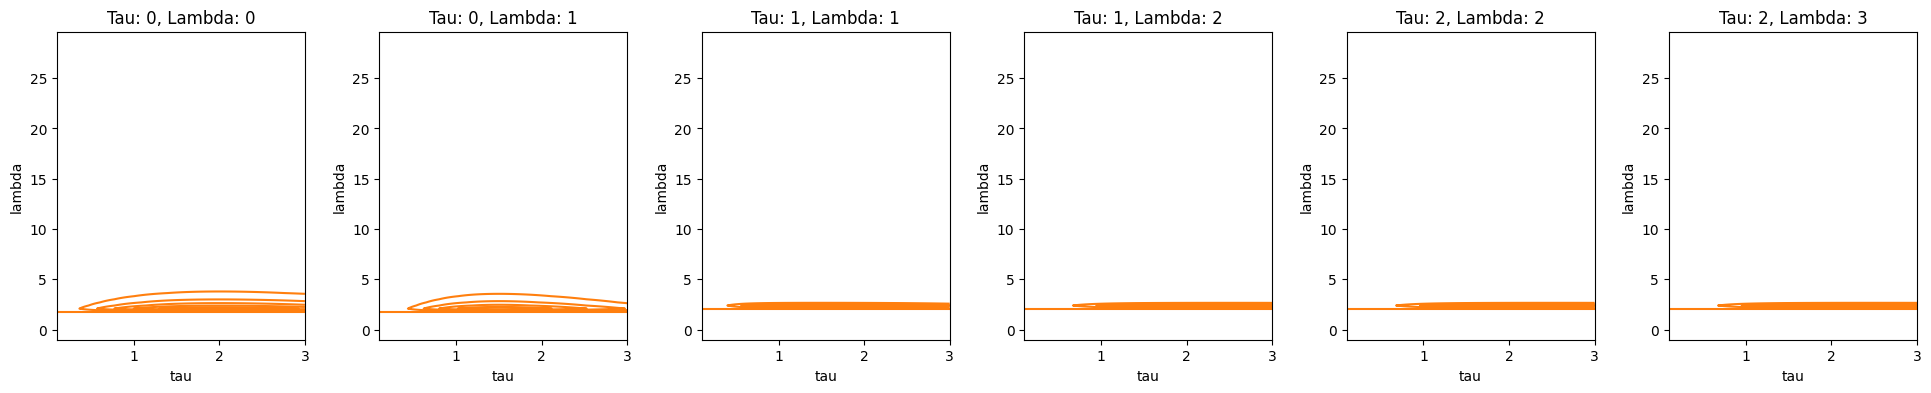

In [31]:
alpha0, gamma, u0, v0 = 2.0, 2.0, 3.0, 1.0

alpha, gamma, u, v = mean_field_approximation(x, alpha0, gamma, u0, v0, iters=100)

tau_min, tau_max = 0.1, 3.0
lmbd_min, lmbd_max = -1, alpha[-1] + 3.0

tau_vals = np.linspace(tau_min, tau_max, 100)
lmbd_vals = np.linspace(lmbd_min, lmbd_max, 100)
tau_grid, lmbd_grid = np.meshgrid(tau_vals, lmbd_vals)

im_num = 6
fig, axs = plt.subplots(1, im_num,figsize=(4*im_num,4))
lmbd_ind, tau_ind = 0, 0

for im in range(im_num):
    f = np.array(
        [gamma_pareto_product(
            tau_grid[i], lmbd_grid[i], alpha[tau_ind], 
            gamma[tau_ind], u[lmbd_ind], 
            v[lmbd_ind])
                  for i in range(len(tau_vals))])
    axs[im].contour(tau_vals, lmbd_vals, f, colors='C1',levels=5)
    axs[im].set_xlabel('tau')
    axs[im].set_ylabel('lambda')
    axs[im].set_title('Tau: {}, Lambda: {}'.format(tau_ind,lmbd_ind))
    if im%2:
        tau_ind += 1
    else:
        lmbd_ind += 1

plt.subplots_adjust(wspace=0.3,hspace=0.3)
print(alpha[-1], gamma[-1], u[-1], v[-1])

## Task 4. VAE on CIFAR-10 dataset (4 pts)

In this task you will implement VAE model for CIFAR10 dataset.

### 4.1 utils for this task

In [32]:
TICKS_FONT_SIZE = 12
LEGEND_FONT_SIZE = 12
LABEL_FONT_SIZE = 14
TITLE_FONT_SIZE = 16

In [33]:
def plot_training_curves(train_losses, test_losses, logscale_y=False, logscale_x=False):
    n_train = len(train_losses[list(train_losses.keys())[0]])
    n_test = len(test_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, n_test - 1, n_train)
    x_test = np.arange(n_test)

    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + '_train')

    for key, value in test_losses.items():
        plt.plot(x_test, value, label=key + '_test')

    if logscale_y:
        plt.semilogy()
    
    if logscale_x:
        plt.semilogx()

    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.xlabel('Epoch', fontsize=LABEL_FONT_SIZE)
    plt.ylabel('Loss', fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    plt.grid()
    plt.show()

In [34]:
def load_CIFAR10():
    train_data = torchvision.datasets.CIFAR10(root="./", train=True, download=True)
    test_data = torchvision.datasets.CIFAR10(root="./", train=False, download=True)
    train_data, test_data = train_data.data, test_data.data

    return train_data, test_data

In [35]:
def _load_dataset(name: str):
   
    if name == "cifar10":
        return load_CIFAR10()
    else:
        raise ValueError("The argument name must have the value  'cifar10'")
        

def load_dataset(
    name, flatten: bool = False, binarize: bool = True
):

    train_data, test_data = _load_dataset(name)

    train_data = train_data.astype("float32")
    test_data = test_data.astype("float32")

    if binarize:
        train_data = (train_data > 128).astype("float32")
        test_data = (test_data > 128).astype("float32")
    else:
        train_data = train_data / 255.0
        test_data = test_data / 255.0

    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    if flatten:
        train_data = train_data.reshape(len(train_data.shape[0]), -1)
        test_data = test_data.reshape(len(train_data.shape[0]), -1)

    return train_data, test_data

In [36]:
def show_samples(
    samples,
    title,
    figsize=None,
    nrow=None,
) -> None:
    
    if isinstance(samples, np.ndarray):
        samples = torch.FloatTensor(samples)
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.imshow(grid_img)
    plt.axis("off")
    plt.show()


def visualize_images(data: np.ndarray, title: str) -> None:
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)

In [37]:
def train_epoch(model, train_loader, optimizer, use_cuda, loss_key='total'):
    model.train()

    stats = defaultdict(list)
    for x in train_loader:
        if use_cuda:
            x = x.cuda()
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())

    return stats


def eval_model(model, data_loader, use_cuda):
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            if use_cuda:
                x = x.cuda()
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(
    model,
    train_loader,
    test_loader,
    epochs,
    lr,
    use_tqdm=False,
    use_cuda=False,
    loss_key='total_loss'
):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    if use_cuda:
        model = model.cuda()

    for epoch in forrange:
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, use_cuda, loss_key)
        test_loss = eval_model(model, test_loader, use_cuda)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)

In [38]:
def get_normal_KL(mean_1, log_std_1, mean_2=None, log_std_2=None):
    """
        This function should return the value of KL(p1 || p2),
        where p1 = Normal(mean_1, exp(log_std_1)), p2 = Normal(mean_2, exp(log_std_2) ** 2).
        If mean_2 and log_std_2 are None values, we will use standard normal distribution.
        Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)
    # ====
    # your code
    
    # ====

    first = 1 / torch.exp(log_std_2) ** 2 * torch.exp(log_std_1) ** 2
    
    second = (mean_2 - mean_1) * (1 / torch.exp(log_std_2) ** 2) * (mean_2 - mean_1)

    third = 1

    fourth = torch.log((torch.exp(log_std_2) ** 2) / (torch.exp(log_std_1) ** 2))

    return 1/2 * (first + second - third + fourth)

In [39]:
def get_normal_nll(x, mean, log_std):
    """
        This function should return the negative log likelihood log p(x),
        where p(x) = Normal(x | mean, exp(log_std) ** 2).
        Note that we consider the case of diagonal covariance matrix.
    """
    # ====
    # your code
    
    # ====

    return log_std + 0.5 * torch.log(torch.tensor(2) * np.pi) + (x - mean) * torch.exp(-2 * log_std) / 2 * (x - mean)


### 4.2 Uploading of data

100%|██████████| 170M/170M [00:06<00:00, 28.2MB/s] 


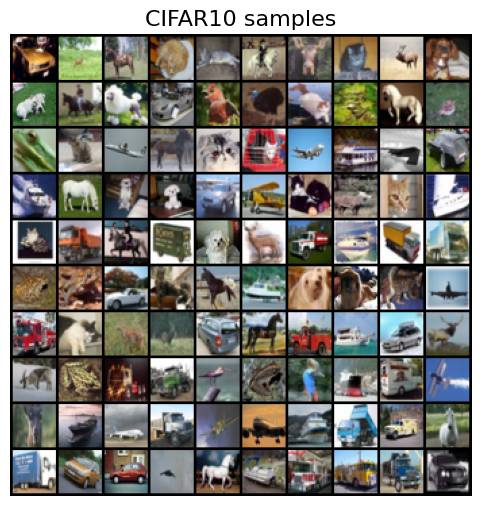

In [40]:
train_data, test_data = load_dataset('cifar10', flatten=False, binarize=False)
visualize_images(train_data, 'CIFAR10 samples')

Here the model specification will be almost the same (as in seminar 7) with the following differences:
* Now our encoder and decoder will be convolutional.
* We do not fit the covariance matrix $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z})$ in the generative distribution $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$. We assume that it is identical ($\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}) = \mathbf{I}$). We will use the $\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z})$ means of the generative distribution $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$ as model samples.
* Model objective is slightly modified ELBO:
$$
    \mathcal{L}(\boldsymbol{\phi}, \boldsymbol{\theta}) = \mathbb{E}_{q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})} \log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) - \beta * KL (q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) || p(\mathbf{z})).
$$
Here we introduce the parameter $\beta$. It reweights KL term in the total loss. We will discuss the choice of this parameter later in the course. In this exercise you have to play with it, starting with the value $\beta = 1$ (standard ELBO).

### 4.3 Convoluitonal Encoder (1 pt)

In this , you should define convolutional encoder that will return means and diagonal deviations.

In [56]:
class ConvEncoder(nn.Module):
    def __init__(self, input_shape, n_latent):
        super().__init__()
        self.input_shape = input_shape
        self.n_latent = n_latent

        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.input_shape[0], 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.AdaptiveAvgPool2d(1),
            nn.ReLU()
        )
        
        self.output_layer = nn.Linear(256, 2 * self.n_latent)
        # ====
        # your code
        # we suggest to use the following architecture
        # conv2d(32) -> relu -> conv(64) -> relu -> conv(128) -> relu -> conv(256) -> fc(2 * n_latent)
        # but we encourage you to create your own architecture
        # ====
         

    def forward(self, x):
        # ====
        # your code
        # 1) apply convs
        # 2) reshape the output to 2d matrix for last fc layer
        # 3) apply fc layer
        # ====
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        out = self.output_layer(x)
        return out[:, :self.n_latent], out[:, self.n_latent:]

### 4.4 Convolutional decoder (1 pt)

In this , you should define convolutional decoder that will return your generated samples

In [57]:
class ConvDecoder(nn.Module):
    def __init__(self, n_latent, output_shape):
        super().__init__()
        self.n_latent = n_latent
        self.output_shape = output_shape

        self.base_size = (128, output_shape[1] // 16, output_shape[2] // 16)
        self.input_layer = nn.Sequential(
            nn.Linear(n_latent, self.base_size[0] * self.base_size[1] * self.base_size[2]),
            nn.ReLU()
        )

        self.conv_layer = nn.Sequential(
            nn.ConvTranspose2d(self.base_size[0], 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
        )
        # ====
        # your code
        # we suggest to use the following architecture
        # fc -> conv2dtranspose(128) -> relu -> conv2dtranspose(64) -> relu 
        # -> conv2dtranspose(32) -> relu -> conv2dtranspose(3)
        # but we encourage you to create your own architecture
        # ====
        

    def forward(self, z):
        # ====
        # your code
        # 1) apply fc layer
        # 2) reshape the output to 4d tensor 
        # 3) apply conv layers
        # ====
        z = self.input_layer(z)
        z = z.view(z.size(0), self.base_size[0], self.base_size[1], self.base_size[2])
        x_hat = self.conv_layer(z)
        return x_hat

### 4.5 Convolutional VAE model (2 pts)

Now it is time to implement VAE model for image dataset.

- Firstly, you should fill function forward (1 pt)
- Secondly, you should fill function loss (1 pt)

In [60]:
class ConvVAE(nn.Module):
    def __init__(self, input_shape, n_latent, beta=1):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.beta = beta
      
        self.encoder = ConvEncoder(self.input_shape, self.n_latent)
        self.decoder = ConvDecoder(self.n_latent, self.input_shape)

    def prior(self, n, use_cuda=True):
     
        z = torch.randn(n, self.n_latent).cuda()
        if use_cuda:
            z = z.cuda()
        return z

    def forward(self, x):
        mu_z, log_std_z = self.encoder(x)
        epsilon = self.prior(n=x.size(0))
        
        z = mu_z + epsilon * torch.exp(log_std_z)
        mu_x = self.decoder(z)
        
        return mu_z, log_std_z, mu_x
        # ====
        # your code
        # 1) apply encoder to get mu_z, log_std_z
        # 2) apply reparametrization trick (use self.prior)
        # 3) apply decoder to get mu_x (which corresponds to reconstructed x)
        # ====
        
    def loss(self, x):
        # ====
        # your code
        # 1) make forward step to get mu_z, log_std_z, x_recon
        # 2) calculate recon_loss (use get_normal_nll)
        # 3) calcucalte kl_loss (use get_normal_KL)
        # ====
        mu_z, log_std_z, mu_x = self.forward(x)
        log_std_x = torch.zeros_like(mu_x)
        
        recon_loss = get_normal_nll(x, mu_x, log_std_x)
        recon_loss = recon_loss.view(recon_loss.size(0), -1).sum(dim=1).mean()
        
        kl_loss = get_normal_KL(mu_z, log_std_z)
        kl_loss = kl_loss.sum(dim=1).mean()
        total_loss = recon_loss + self.beta * kl_loss

        return {
            'elbo_loss': total_loss,
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }        
   

    def sample(self, n):
        with torch.no_grad():
            x_recon = self.decoder(self.prior(n))
            samples = torch.clamp(x_recon, -1, 1)
        return samples.cpu().numpy() * 0.5 + 0.5

### 4.6 Training

In [67]:
# ====
# your code
# choose these parameters

BATCH_SIZE = 64# any adequate value
EPOCHS =  15  # < 16
LR =     1e-4     # < 1e-3
N_LATENS =  250  # 128 < _ < 1024
BETA =    2.3   # 0.1 < _ < 10
# ====

# we center the data, because it helps the model to fit
centered_train_data = train_data * 2 - 1
centered_test_data = test_data * 2 - 1

train_loader = torch.utils.data.DataLoader(centered_train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(centered_test_data, batch_size=BATCH_SIZE)

model = ConvVAE((3, 32, 32), N_LATENS, BETA)

train_losses, test_losses = train_model(
    model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    loss_key='elbo_loss', 
    use_tqdm=True, 
    use_cuda=True, 
)

100%|██████████| 15/15 [01:42<00:00,  6.85s/it]


elbo_loss: 2998.1494
recon_loss: 2965.7653
kl_loss: 14.0801


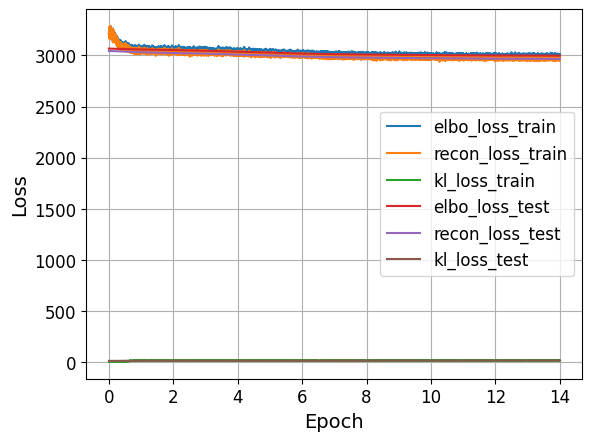

In [68]:
for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
plot_training_curves(train_losses, test_losses)

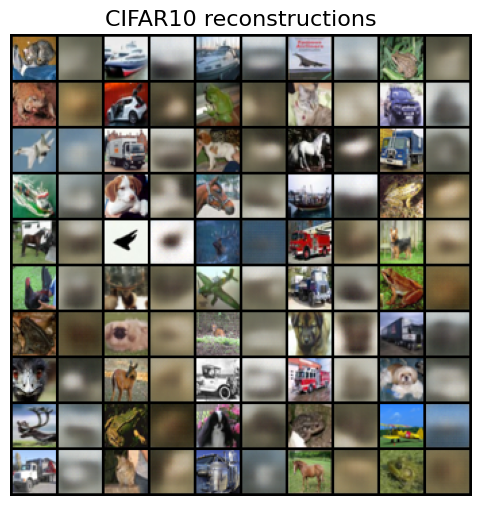

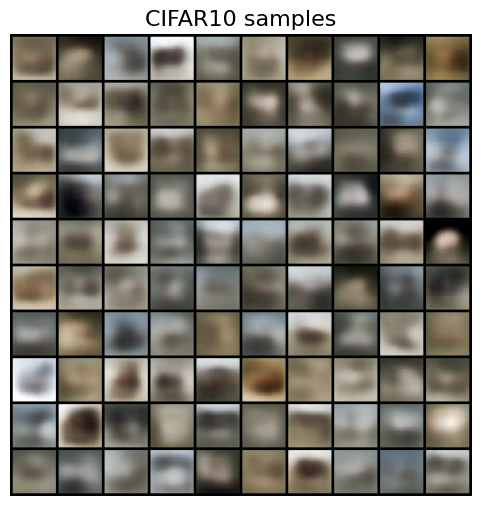

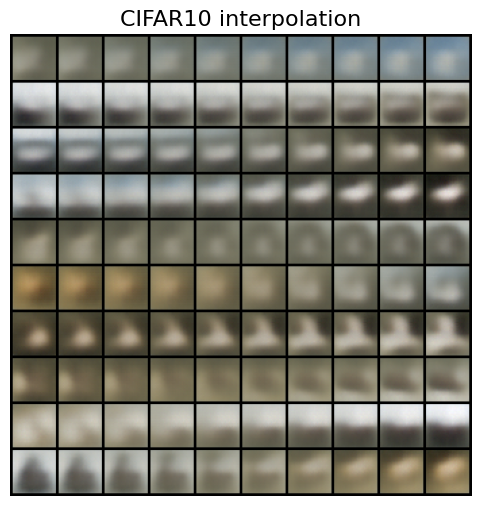

In [69]:
samples = model.sample(100)
USE_CUDA=True
x = next(iter(test_loader))[:50]

if USE_CUDA:
    x = x.cuda()

with torch.no_grad():
    z, _ = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

x = next(iter(test_loader))[:20].cuda()
with torch.no_grad():
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.cpu().numpy()

show_samples(reconstructions, 'CIFAR10 reconstructions')
show_samples(samples, 'CIFAR10 samples')
show_samples(interps, 'CIFAR10 interpolation')